### Environment

In [1]:
%load_ext autoreload
%autoreload 2
%pylab
%matplotlib inline

import pandas as pd
import pickle
import numpy as np
import sys
import os

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.append('../')
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

### Configuration

In [3]:
from sv_system.utils.parser import set_train_config
import easydict

args = easydict.EasyDict(dict(dataset="voxc1_fbank_xvector", 
                              data_folder="/dataset/SV_sets/voxceleb12/feats/fbank64_vad/",
                              input_frames=400, splice_frames=[200, 400], stride_frames=1, 
                              input_format='fbank', input_dim=65, random_clip=True,
                              n_epochs=120, lrs=[0.1, 0.01], lr_schedule=[20], seed=1337,
                              no_eer=False, batch_size=128,
                              gpu_no=[0], cuda=True, num_workers=8,
                              arch="tdnn_conv", loss="softmax",
                             ))
config = set_train_config(args)

### Dataset

In [4]:
# voxceleb1
dev_df = pd.read_csv("/dataset/SV_sets/voxceleb1/dataframes/voxc1_dev.csv")
dev_df['label'] = dev_df.groupby("spk").ngroup()
spk_counts = dev_df.spk.value_counts()
dev_train_df = dev_df[dev_df.set == 'train']
dev_val_df = dev_df[dev_df.set == 'val']

eval_df = pd.read_csv("/dataset/SV_sets/voxceleb1/dataframes/voxc1_eval.csv")
eval_df['label'] = eval_df.groupby('spk').ngroup()

In [5]:
# voxceleb2
# dev_df = pd.read_csv("/dataset/SV_sets/voxceleb2/dataframes/voxc2_si.csv")
# dev_train_df = dev_df[dev_df.set == 'train']
# dev_val_df = dev_df[dev_df.set == 'val']
# eval_df = pd.read_csv("/dataset/SV_sets/voxceleb2/dataframes/voxc2_sv.csv")

In [6]:
from sv_system.data.feat_dataset import FeatDataset

dev_train_dataset = FeatDataset.read_df(config, dev_train_df, 'train')
dev_val_dataset = FeatDataset.read_df(config, dev_val_df, 'test')
eval_dataset = FeatDataset.read_df(config, eval_df, 'test')

### Dataloader

In [7]:
from sv_system.data.dataloader import init_default_loader 
dev_train_dataloader = init_default_loader(config, dev_train_dataset, shuffle=True, var_len=False) 
dev_val_dataloader = init_default_loader(config, dev_val_dataset, shuffle=False, var_len=False) 
eval_dataloader = init_default_loader(config, eval_dataset, shuffle=False, var_len=True) 

### Model

In [8]:
import torch
from tdnn_models import tdnn_xvector_se
from tdnn_models import tdnn_xvector

model = tdnn_xvector_se(config, 512, n_labels=len(dev_df.label.unique()))
# saved_model = torch.load("trained_models/voxc1_small_dev_time_reduction.pt")
# model.load_state_dict(saved_model)

if not config['no_cuda']:
    model = model.cuda()

In [9]:
import torch.nn as nn
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
from sklearn.metrics import roc_curve
import torch.nn.functional as F
from tensorboardX import SummaryWriter
from tqdm import tqdm

optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001, nesterov=True)
from fine_tune_utils import class_weight
# criterion = nn.CrossEntropyLoss(weight=class_weight(config, dev_train_df))
criterion = nn.CrossEntropyLoss()
# plateau_scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5)
step_scheduler = MultiStepLR(optimizer, [30, 50, 70], 0.2)

writer = SummaryWriter("logs/tdnn_xvector_voxc1_se_1")
model_path = "trained_models/voxc1_tdnn_xvector_se_1.pt"

for epoch_idx in range(0, config['n_epochs']):
    step_scheduler.step()
    print("-"*30)
    curr_lr = optimizer.state_dict()['param_groups'][0]['lr']
    print("curr_lr: {}".format(curr_lr))
    
# =============== train code #===============
    model.train()
    loss_sum = 0
    n_corrects = 0
    total = 0
    for batch_idx, (X, y) in tqdm(enumerate(dev_train_dataloader), ascii=None, total=len(dev_train_dataloader)):
        if not config['no_cuda']:
            X = X.cuda()
            y = y.cuda()

        optimizer.zero_grad()
        logit = model(X)
        loss = criterion(logit, y)
        loss.backward()
        optimizer.step()
                        
        loss_sum += loss.item()
        n_corrects += logit.max(1)[1].eq(y).sum().item()
        total += y.size(0)
#         if (batch_idx+1) % 1000 == 0:
#             print("Batch {}/{}\t Loss {:.6f}" \
#                   .format(batch_idx+1, len(si_loader), loss_sum / total))
    train_loss = loss_sum / total
    train_acc = n_corrects / total
#     plateau_scheduler.step(train_loss)
    
    print("epoch #{}, train loss: {:.4f}, train acc: {:.4f}".format(epoch_idx, train_loss, train_acc))
    writer.add_scalar("train/loss", train_loss, epoch_idx+1)
    writer.add_scalar("train/acc", train_acc, epoch_idx+1)

#=============== dev_val code #===============
    model.eval()
    loss_sum = 0
    n_corrects = 0
    total = 0
    for batch_idx, (X, y) in enumerate(dev_val_dataloader):
        if not config['no_cuda']:
            X = X.cuda()
            y = y.cuda()

        logit = model(X)
        loss = criterion(logit, y)
        loss_sum += loss.item()
        n_corrects += logit.max(1)[1].eq(y).sum().item()
        total += y.size(0)
    val_loss = loss_sum / total
    val_acc = n_corrects / total
    
    print("epoch #{}, val loss: {:.4f}, val acc: {:.4f}".format(epoch_idx, val_loss, val_acc))
    writer.add_scalar("val/loss", val_loss, epoch_idx+1)
    writer.add_scalar("val/acc", val_acc, epoch_idx+1)
    
#=============== model save #===============
    torch.save(model.state_dict(), model_path)

------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  8.03it/s]

epoch #0, train loss: 0.0452, train acc: 0.0280


epoch #0, val loss: 0.0446, val acc: 0.0250
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  8.01it/s]

epoch #1, train loss: 0.0322, train acc: 0.1403


epoch #1, val loss: 0.0379, val acc: 0.0902
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  8.01it/s]

epoch #2, train loss: 0.0240, train acc: 0.2969


epoch #2, val loss: 0.0330, val acc: 0.1698
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  8.02it/s]

epoch #3, train loss: 0.0177, train acc: 0.4512


epoch #3, val loss: 0.0291, val acc: 0.2325
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  8.01it/s]

epoch #4, train loss: 0.0133, train acc: 0.5686


epoch #4, val loss: 0.0272, val acc: 0.2913
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #5, train loss: 0.0102, train acc: 0.6606


epoch #5, val loss: 0.0250, val acc: 0.3383
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #6, train loss: 0.0080, train acc: 0.7284


epoch #6, val loss: 0.0225, val acc: 0.3907
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #7, train loss: 0.0064, train acc: 0.7771


epoch #7, val loss: 0.0221, val acc: 0.4162
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  8.00it/s]

epoch #8, train loss: 0.0051, train acc: 0.8200


epoch #8, val loss: 0.0218, val acc: 0.4237
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  8.01it/s]

epoch #9, train loss: 0.0042, train acc: 0.8487


epoch #9, val loss: 0.0195, val acc: 0.4788
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  8.00it/s]

epoch #10, train loss: 0.0034, train acc: 0.8746


epoch #10, val loss: 0.0185, val acc: 0.5023
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #11, train loss: 0.0029, train acc: 0.8946


epoch #11, val loss: 0.0190, val acc: 0.5069
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #12, train loss: 0.0025, train acc: 0.9078


epoch #12, val loss: 0.0179, val acc: 0.5223
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  8.01it/s]

epoch #13, train loss: 0.0022, train acc: 0.9185


epoch #13, val loss: 0.0167, val acc: 0.5557
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #14, train loss: 0.0019, train acc: 0.9290


epoch #14, val loss: 0.0184, val acc: 0.5192
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  7.97it/s]

epoch #15, train loss: 0.0017, train acc: 0.9357


epoch #15, val loss: 0.0162, val acc: 0.5602
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  7.97it/s]

epoch #16, train loss: 0.0015, train acc: 0.9459


epoch #16, val loss: 0.0150, val acc: 0.5907
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #17, train loss: 0.0013, train acc: 0.9526


epoch #17, val loss: 0.0158, val acc: 0.5801
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #18, train loss: 0.0013, train acc: 0.9524


epoch #18, val loss: 0.0154, val acc: 0.5815
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #19, train loss: 0.0013, train acc: 0.9551


epoch #19, val loss: 0.0150, val acc: 0.5914
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  8.00it/s]

epoch #20, train loss: 0.0012, train acc: 0.9571


epoch #20, val loss: 0.0154, val acc: 0.5819
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #21, train loss: 0.0012, train acc: 0.9590


epoch #21, val loss: 0.0163, val acc: 0.5684
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #22, train loss: 0.0011, train acc: 0.9630


epoch #22, val loss: 0.0139, val acc: 0.6154
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #23, train loss: 0.0011, train acc: 0.9640


epoch #23, val loss: 0.0142, val acc: 0.6089
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #24, train loss: 0.0010, train acc: 0.9671


epoch #24, val loss: 0.0144, val acc: 0.5994
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #25, train loss: 0.0010, train acc: 0.9662


epoch #25, val loss: 0.0141, val acc: 0.6125
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  7.97it/s]

epoch #26, train loss: 0.0010, train acc: 0.9665


epoch #26, val loss: 0.0146, val acc: 0.6007
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  7.97it/s]

epoch #27, train loss: 0.0010, train acc: 0.9673


epoch #27, val loss: 0.0139, val acc: 0.6135
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  7.97it/s]

epoch #28, train loss: 0.0009, train acc: 0.9719


epoch #28, val loss: 0.0132, val acc: 0.6310
------------------------------
curr_lr: 0.1


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #29, train loss: 0.0009, train acc: 0.9712


epoch #29, val loss: 0.0136, val acc: 0.6166
------------------------------
curr_lr: 0.020000000000000004


100%|██████████| 549/549 [01:08<00:00,  7.97it/s]

epoch #30, train loss: 0.0003, train acc: 0.9938


epoch #30, val loss: 0.0085, val acc: 0.7487
------------------------------
curr_lr: 0.020000000000000004


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #31, train loss: 0.0001, train acc: 0.9979


epoch #31, val loss: 0.0081, val acc: 0.7577
------------------------------
curr_lr: 0.020000000000000004


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #32, train loss: 0.0001, train acc: 0.9988


epoch #32, val loss: 0.0080, val acc: 0.7595
------------------------------
curr_lr: 0.020000000000000004


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #33, train loss: 0.0001, train acc: 0.9991


epoch #33, val loss: 0.0077, val acc: 0.7667
------------------------------
curr_lr: 0.020000000000000004


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #34, train loss: 0.0001, train acc: 0.9993


epoch #34, val loss: 0.0076, val acc: 0.7701
------------------------------
curr_lr: 0.020000000000000004


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #35, train loss: 0.0001, train acc: 0.9994


epoch #35, val loss: 0.0075, val acc: 0.7692
------------------------------
curr_lr: 0.020000000000000004


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #36, train loss: 0.0001, train acc: 0.9994


epoch #36, val loss: 0.0074, val acc: 0.7753
------------------------------
curr_lr: 0.020000000000000004


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #37, train loss: 0.0001, train acc: 0.9995


epoch #37, val loss: 0.0074, val acc: 0.7739
------------------------------
curr_lr: 0.020000000000000004


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #38, train loss: 0.0001, train acc: 0.9996


epoch #38, val loss: 0.0074, val acc: 0.7725
------------------------------
curr_lr: 0.020000000000000004


100%|██████████| 549/549 [01:08<00:00,  7.97it/s]

epoch #39, train loss: 0.0001, train acc: 0.9997


epoch #39, val loss: 0.0072, val acc: 0.7796
------------------------------
curr_lr: 0.020000000000000004


100%|██████████| 549/549 [01:08<00:00,  8.01it/s]

epoch #40, train loss: 0.0001, train acc: 0.9997


epoch #40, val loss: 0.0072, val acc: 0.7795
------------------------------
curr_lr: 0.020000000000000004


100%|██████████| 549/549 [01:08<00:00,  8.00it/s]

epoch #41, train loss: 0.0001, train acc: 0.9999


epoch #41, val loss: 0.0071, val acc: 0.7805
------------------------------
curr_lr: 0.020000000000000004


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #42, train loss: 0.0001, train acc: 0.9998


epoch #42, val loss: 0.0071, val acc: 0.7806
------------------------------
curr_lr: 0.020000000000000004


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #43, train loss: 0.0001, train acc: 0.9998


epoch #43, val loss: 0.0071, val acc: 0.7841
------------------------------
curr_lr: 0.020000000000000004


100%|██████████| 549/549 [01:08<00:00,  7.97it/s]

epoch #44, train loss: 0.0001, train acc: 0.9998


epoch #44, val loss: 0.0070, val acc: 0.7849
------------------------------
curr_lr: 0.020000000000000004


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #45, train loss: 0.0001, train acc: 0.9999


epoch #45, val loss: 0.0070, val acc: 0.7871
------------------------------
curr_lr: 0.020000000000000004


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #46, train loss: 0.0001, train acc: 0.9998


epoch #46, val loss: 0.0070, val acc: 0.7876
------------------------------
curr_lr: 0.020000000000000004


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #47, train loss: 0.0001, train acc: 0.9998


epoch #47, val loss: 0.0069, val acc: 0.7903
------------------------------
curr_lr: 0.020000000000000004


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #48, train loss: 0.0001, train acc: 0.9998


epoch #48, val loss: 0.0070, val acc: 0.7881
------------------------------
curr_lr: 0.020000000000000004


100%|██████████| 549/549 [01:08<00:00,  7.97it/s]

epoch #49, train loss: 0.0001, train acc: 0.9999


epoch #49, val loss: 0.0069, val acc: 0.7895
------------------------------
curr_lr: 0.004000000000000001


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #50, train loss: 0.0001, train acc: 0.9999


epoch #50, val loss: 0.0069, val acc: 0.7896
------------------------------
curr_lr: 0.004000000000000001


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #51, train loss: 0.0001, train acc: 0.9999


epoch #51, val loss: 0.0068, val acc: 0.7915
------------------------------
curr_lr: 0.004000000000000001


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #52, train loss: 0.0001, train acc: 0.9999


epoch #52, val loss: 0.0068, val acc: 0.7916
------------------------------
curr_lr: 0.004000000000000001


100%|██████████| 549/549 [01:08<00:00,  7.97it/s]

epoch #53, train loss: 0.0001, train acc: 0.9999


epoch #53, val loss: 0.0069, val acc: 0.7902
------------------------------
curr_lr: 0.004000000000000001


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #54, train loss: 0.0001, train acc: 0.9999


epoch #54, val loss: 0.0068, val acc: 0.7901
------------------------------
curr_lr: 0.004000000000000001


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #55, train loss: 0.0001, train acc: 0.9999


epoch #55, val loss: 0.0068, val acc: 0.7912
------------------------------
curr_lr: 0.004000000000000001


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #56, train loss: 0.0001, train acc: 0.9999


epoch #56, val loss: 0.0068, val acc: 0.7918
------------------------------
curr_lr: 0.004000000000000001


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #57, train loss: 0.0001, train acc: 1.0000


epoch #57, val loss: 0.0068, val acc: 0.7920
------------------------------
curr_lr: 0.004000000000000001


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #58, train loss: 0.0001, train acc: 1.0000


epoch #58, val loss: 0.0068, val acc: 0.7922
------------------------------
curr_lr: 0.004000000000000001


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #59, train loss: 0.0001, train acc: 0.9999


epoch #59, val loss: 0.0068, val acc: 0.7910
------------------------------
curr_lr: 0.004000000000000001


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #60, train loss: 0.0001, train acc: 0.9999


epoch #60, val loss: 0.0068, val acc: 0.7926
------------------------------
curr_lr: 0.004000000000000001


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #61, train loss: 0.0001, train acc: 1.0000


epoch #61, val loss: 0.0068, val acc: 0.7919
------------------------------
curr_lr: 0.004000000000000001


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #62, train loss: 0.0001, train acc: 0.9999


epoch #62, val loss: 0.0068, val acc: 0.7936
------------------------------
curr_lr: 0.004000000000000001


100%|██████████| 549/549 [01:08<00:00,  7.97it/s]

epoch #63, train loss: 0.0001, train acc: 0.9999


epoch #63, val loss: 0.0068, val acc: 0.7924
------------------------------
curr_lr: 0.004000000000000001


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #64, train loss: 0.0001, train acc: 1.0000


epoch #64, val loss: 0.0068, val acc: 0.7950
------------------------------
curr_lr: 0.004000000000000001


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #65, train loss: 0.0001, train acc: 0.9999


epoch #65, val loss: 0.0068, val acc: 0.7942
------------------------------
curr_lr: 0.004000000000000001


100%|██████████| 549/549 [01:08<00:00,  7.97it/s]

epoch #66, train loss: 0.0001, train acc: 0.9999


epoch #66, val loss: 0.0068, val acc: 0.7928
------------------------------
curr_lr: 0.004000000000000001


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #67, train loss: 0.0001, train acc: 0.9999


epoch #67, val loss: 0.0068, val acc: 0.7945
------------------------------
curr_lr: 0.004000000000000001


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #68, train loss: 0.0001, train acc: 0.9999


epoch #68, val loss: 0.0068, val acc: 0.7953
------------------------------
curr_lr: 0.004000000000000001


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #69, train loss: 0.0001, train acc: 1.0000


epoch #69, val loss: 0.0068, val acc: 0.7951
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #70, train loss: 0.0001, train acc: 1.0000


epoch #70, val loss: 0.0068, val acc: 0.7944
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #71, train loss: 0.0001, train acc: 1.0000


epoch #71, val loss: 0.0068, val acc: 0.7950
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #72, train loss: 0.0001, train acc: 1.0000


epoch #72, val loss: 0.0068, val acc: 0.7951
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  7.97it/s]

epoch #73, train loss: 0.0001, train acc: 0.9999


epoch #73, val loss: 0.0068, val acc: 0.7944
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #74, train loss: 0.0001, train acc: 0.9999


epoch #74, val loss: 0.0068, val acc: 0.7941
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #75, train loss: 0.0001, train acc: 1.0000


epoch #75, val loss: 0.0068, val acc: 0.7939
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #76, train loss: 0.0001, train acc: 1.0000


epoch #76, val loss: 0.0068, val acc: 0.7943
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.00it/s]

epoch #77, train loss: 0.0001, train acc: 1.0000


epoch #77, val loss: 0.0068, val acc: 0.7933
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.00it/s]

epoch #78, train loss: 0.0001, train acc: 1.0000


epoch #78, val loss: 0.0068, val acc: 0.7947
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #79, train loss: 0.0001, train acc: 1.0000


epoch #79, val loss: 0.0068, val acc: 0.7931
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.02it/s]

epoch #80, train loss: 0.0001, train acc: 1.0000


epoch #80, val loss: 0.0068, val acc: 0.7939
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #81, train loss: 0.0001, train acc: 1.0000


epoch #81, val loss: 0.0068, val acc: 0.7936
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #82, train loss: 0.0001, train acc: 1.0000


epoch #82, val loss: 0.0068, val acc: 0.7935
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #83, train loss: 0.0001, train acc: 1.0000


epoch #83, val loss: 0.0068, val acc: 0.7941
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #84, train loss: 0.0001, train acc: 0.9999


epoch #84, val loss: 0.0068, val acc: 0.7933
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #85, train loss: 0.0001, train acc: 1.0000


epoch #85, val loss: 0.0068, val acc: 0.7939
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #86, train loss: 0.0001, train acc: 1.0000


epoch #86, val loss: 0.0068, val acc: 0.7940
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #87, train loss: 0.0001, train acc: 0.9999


epoch #87, val loss: 0.0068, val acc: 0.7940
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #88, train loss: 0.0001, train acc: 1.0000


epoch #88, val loss: 0.0068, val acc: 0.7939
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  7.97it/s]

epoch #89, train loss: 0.0001, train acc: 0.9999


epoch #89, val loss: 0.0068, val acc: 0.7931
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.00it/s]

epoch #90, train loss: 0.0001, train acc: 1.0000


epoch #90, val loss: 0.0068, val acc: 0.7950
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #91, train loss: 0.0001, train acc: 1.0000


epoch #91, val loss: 0.0068, val acc: 0.7941
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #92, train loss: 0.0001, train acc: 1.0000


epoch #92, val loss: 0.0068, val acc: 0.7938
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.01it/s]

epoch #93, train loss: 0.0001, train acc: 1.0000


epoch #93, val loss: 0.0068, val acc: 0.7944
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.02it/s]

epoch #94, train loss: 0.0001, train acc: 1.0000


epoch #94, val loss: 0.0068, val acc: 0.7941
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #95, train loss: 0.0001, train acc: 1.0000


epoch #95, val loss: 0.0068, val acc: 0.7943
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.02it/s]

epoch #96, train loss: 0.0001, train acc: 1.0000


epoch #96, val loss: 0.0068, val acc: 0.7957
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.01it/s]

epoch #97, train loss: 0.0001, train acc: 1.0000


epoch #97, val loss: 0.0068, val acc: 0.7949
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  7.99it/s]

epoch #98, train loss: 0.0001, train acc: 1.0000


epoch #98, val loss: 0.0068, val acc: 0.7957
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.02it/s]

epoch #99, train loss: 0.0001, train acc: 1.0000


epoch #99, val loss: 0.0068, val acc: 0.7962
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.02it/s]

epoch #100, train loss: 0.0001, train acc: 1.0000


epoch #100, val loss: 0.0068, val acc: 0.7936
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.01it/s]

epoch #101, train loss: 0.0001, train acc: 1.0000


epoch #101, val loss: 0.0068, val acc: 0.7962
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.01it/s]

epoch #102, train loss: 0.0001, train acc: 1.0000


epoch #102, val loss: 0.0068, val acc: 0.7946
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.00it/s]

epoch #103, train loss: 0.0001, train acc: 1.0000


epoch #103, val loss: 0.0068, val acc: 0.7946
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.02it/s]

epoch #104, train loss: 0.0001, train acc: 1.0000


epoch #104, val loss: 0.0068, val acc: 0.7960
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.01it/s]

epoch #105, train loss: 0.0001, train acc: 1.0000


epoch #105, val loss: 0.0068, val acc: 0.7943
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.01it/s]

epoch #106, train loss: 0.0001, train acc: 0.9999


epoch #106, val loss: 0.0068, val acc: 0.7960
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.01it/s]

epoch #107, train loss: 0.0001, train acc: 1.0000


epoch #107, val loss: 0.0067, val acc: 0.7953
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.02it/s]

epoch #108, train loss: 0.0001, train acc: 0.9999


epoch #108, val loss: 0.0068, val acc: 0.7959
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.03it/s]

epoch #109, train loss: 0.0001, train acc: 1.0000


epoch #109, val loss: 0.0068, val acc: 0.7950
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.00it/s]

epoch #110, train loss: 0.0001, train acc: 0.9999


epoch #110, val loss: 0.0068, val acc: 0.7954
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.02it/s]

epoch #111, train loss: 0.0001, train acc: 1.0000


epoch #111, val loss: 0.0067, val acc: 0.7958
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.02it/s]

epoch #112, train loss: 0.0001, train acc: 1.0000


epoch #112, val loss: 0.0068, val acc: 0.7951
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.02it/s]

epoch #113, train loss: 0.0001, train acc: 1.0000


epoch #113, val loss: 0.0068, val acc: 0.7950
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.02it/s]

epoch #114, train loss: 0.0001, train acc: 0.9999


epoch #114, val loss: 0.0068, val acc: 0.7970
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.02it/s]

epoch #115, train loss: 0.0001, train acc: 1.0000


epoch #115, val loss: 0.0068, val acc: 0.7953
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.03it/s]

epoch #116, train loss: 0.0001, train acc: 1.0000


epoch #116, val loss: 0.0067, val acc: 0.7957
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.03it/s]

epoch #117, train loss: 0.0001, train acc: 1.0000


epoch #117, val loss: 0.0067, val acc: 0.7957
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  7.98it/s]

epoch #118, train loss: 0.0001, train acc: 1.0000


epoch #118, val loss: 0.0068, val acc: 0.7943
------------------------------
curr_lr: 0.0008000000000000003


100%|██████████| 549/549 [01:08<00:00,  8.01it/s]

epoch #119, train loss: 0.0001, train acc: 1.0000


epoch #119, val loss: 0.0068, val acc: 0.7940


In [10]:
## =============== dev_val code #===============
model.eval()
loss_sum = 0
n_corrects = 0
total = 0
for batch_idx, (X, y) in enumerate(dev_val_dataloader):
    if not config['no_cuda']:
        X = X.cuda()
        y = y.cuda()

    logit = model(X)
    loss = criterion(logit, y)
    loss_sum += loss.item()
    n_corrects += logit.max(1)[1].eq(y).sum().item()
    total += y.size(0)
val_loss = loss_sum / total
val_acc = n_corrects / total

print("epoch #{}, val loss: {:.4f}, val acc: {:.4f}".format(epoch_idx, val_loss, val_acc))

NameError: name 'criterion' is not defined

In [11]:
# See, Attention map
att_maps = []
model.eval()
total = 0
for batch_idx, (X, y) in enumerate(dev_train_dataloader):
    if not config['no_cuda']:
        X = X.cuda()
        y = y.cuda()

    att_map = model.att_map(X).cpu().detach().numpy()
    att_maps.append(att_map)
    break
    

In [22]:
# See, Fr features
fr_feats = []
model.eval()
total = 0
for batch_idx, (X, y) in enumerate(dev_val_dataloader):
    if not config['no_cuda']:
        X = X.cuda()
        y = y.cuda()

    fr_feat = model.fr_feat(X).cpu().detach()
    fr_feats.append(fr_feat)
    break

In [23]:
from torch.nn.functional import cosine_similarity as cosine
cosine(fr_feats[0][0,:,0:1], fr_feats[0][0,:,1:], dim=0)

tensor([0.4115, 0.4619, 0.2880, 0.1456, 0.2449, 0.2377, 0.1846, 0.2711, 0.3090,
        0.2152, 0.3659, 0.2667, 0.3660, 0.3011, 0.2163, 0.4169, 0.4812, 0.4101,
        0.3309, 0.3308, 0.3580, 0.2597, 0.3758, 0.0898, 0.4742, 0.2708, 0.1194,
        0.3323, 0.1286, 0.2033, 0.1993, 0.2460, 0.2657, 0.3245, 0.3804, 0.3026,
        0.1827, 0.2627, 0.2961, 0.2626, 0.3103, 0.3536, 0.5638, 0.2204, 0.3099,
        0.2129])

In [17]:
fr_feats[0][1].shape

torch.Size([1500, 47])

(array([ 2.,  1.,  0.,  0.,  0.,  0.,  0.,  0., 18., 26.]),
 array([0.00847906, 0.00992662, 0.01137418, 0.01282174, 0.0142693 ,
        0.01571687, 0.01716443, 0.01861199, 0.02005955, 0.02150711,
        0.02295467], dtype=float32),
 <a list of 10 Patch objects>)

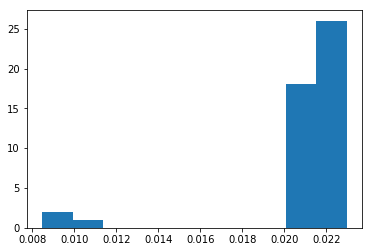

In [42]:
plt.hist(att_maps[0][15])

In [43]:
att_maps[0][15]

array([0.02295467, 0.02295467, 0.02223028, 0.02295467, 0.02295467,
       0.02295467, 0.02113651, 0.02113651, 0.02295467, 0.02295467,
       0.00886847, 0.01112725, 0.02295467, 0.02295467, 0.02113651,
       0.02182527, 0.02295467, 0.02193193, 0.02295467, 0.02113651,
       0.02113651, 0.02295467, 0.02113651, 0.02113651, 0.02113651,
       0.02295467, 0.02295467, 0.02223028, 0.02113651, 0.02113651,
       0.02113651, 0.02113651, 0.02182527, 0.02295467, 0.00847906,
       0.02295467, 0.02295467, 0.02193193, 0.02295467, 0.02295467,
       0.02295467, 0.02113651, 0.02113651, 0.02113651, 0.02113651,
       0.02113651, 0.02113651], dtype=float32)

### LDA on embedding

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

global_mean = si_embeds.mean(0)
clf = LDA(solver='svd', n_components=200)
clf.fit(si_embeds - global_mean, si_key_df.label)

si_embeds = clf.transform(si_embeds - global_mean).astype(np.float32)

sv_embeds = clf.transform(sv_embeds - global_mean).astype(np.float32)

si_dataset, embed_dim, n_labels = embedToDataset(si_embeds.reshape(-1,200), si_key_df)
sv_dataset, _, _ = embedToDataset(sv_embeds, sv_key_df)